## SimCLR model training
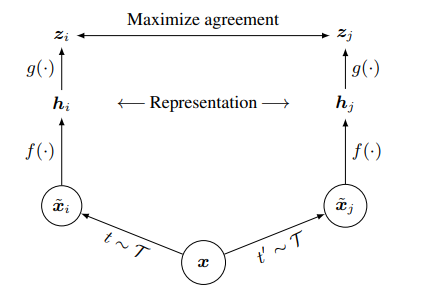

### Introduction
SimCLR (Simple Framework for Contrastive Learning of Visual Representations) is a **self-supervised learning** method developed by Google Brain. It learns **visual representations** without requiring labeled data by leveraging contrastive learning.

### Key Concepts
- **Contrastive Learning**: The model learns by pulling similar images **closer** (positive pairs) and pushing different images **apart** (negative pairs).
- **Augmentations**: Each image is transformed into two different **views** using random augmentations (e.g., cropping, color jittering, flipping).
- **Projection Head**: A small MLP head maps features to a lower-dimensional **embedding space** for contrastive learning.
- **NT-Xent Loss**: Normalized Temperature-scaled Cross Entropy Loss ensures that similar images are **closer** in the embedding space.

### Training Process
1. **Image Augmentation**: Each image is randomly augmented into two different views.
2. **Feature Extraction**: A backbone encoder (e.g., **ResNet-18**) extracts features.
3. **Projection Head**: Features pass through an MLP to create embeddings.
4. **Contrastive Loss**: The NT-Xent loss minimizes the distance between positive pairs and maximizes it for negative pairs.
5. **Fine-Tuning**: After pretraining, the encoder is used for downstream tasks (e.g., classification).

### Applications
- Image classification (without labeled data)
- Transfer learning (pretrained models on new tasks)
- Representation learning for vision tasks

Here according to the SimCLR paper I have used random croppings and color perturbations as augmentation methods.

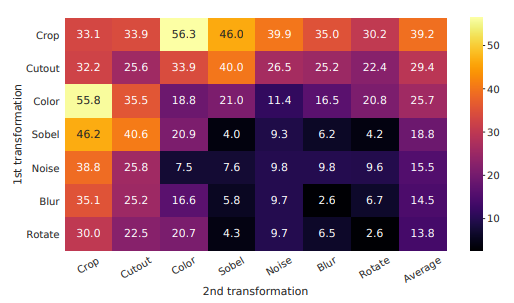



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader

## Data transformations


In [ ]:
# SimCLR Transformations
class SimCLRTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=32),
            transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

# Download CIFAR-10 Dataset
batch_size = 256

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=SimCLRTransform(), download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=SimCLRTransform(), download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

##SimCLR Model

SimCLR consists of two main components:
1. **Encoder**: Extracts meaningful features from images.
2. **Projection Head**: Maps features to a lower-dimensional space for contrastive learning.

        

### 1. Encoder: Feature Extraction with ResNet18
A **ResNet-18** backbone is used as the encoder. The **fully connected (FC) classification layer** is removed to keep only feature extraction layers.

```python
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        base_model = models.resnet18(pretrained=False)
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])  # Remove FC layer

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)  # Flatten the output
        

###2. Projection Head: Mapping to Latent Space

The extracted features are passed through a **two-layer MLP** that transforms them into a **lower-dimensional** 128-dimensional embedding.

```python
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=512, output_dim=128):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply ReLU activation
        return self.fc2(x)  # Output embedding
        

In [ ]:
# Encoder: ResNet18 (removing classification head)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        base_model = models.resnet18(pretrained=False)
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])  # Remove last FC layer

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)  # Flatten

# Projection Head: 2-layer MLP
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=512, output_dim=128):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# SimCLR Model
class SimCLR(nn.Module):
    def __init__(self):
        super(SimCLR, self).__init__()
        self.encoder = Encoder()
        self.projection_head = ProjectionHead()

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        return z

## Training

Here the NT-xnet loss is defined as follows

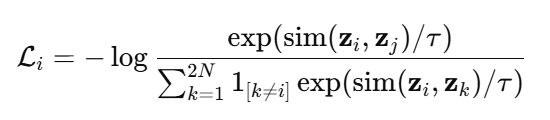

Similarity is defined as the **cosine similarity** between the two vectors

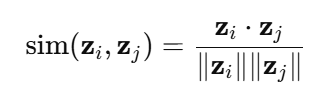

The **temperature parameter** defines the sharpness of the similarity distribution.

In [13]:
import matplotlib.pyplot as plt
import torch.optim as optim

# NT-Xent Loss
def nt_xent_loss(z_i, z_j, temperature=0.5):
  '''Compute NT-Xent loss'''
    batch_size = z_i.shape[0]
    z = torch.cat([z_i, z_j], dim=0)  # Concatenate positive pairs

    # Compute similarity
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
    sim /= temperature

    # Create labels
    labels = torch.arange(batch_size, device=z.device).repeat(2)
    loss = F.cross_entropy(sim, labels)
    return loss

def train_simclr(model, train_loader, optimizer, device, epochs=10):
  '''Train SimCLR model'''
    model.train()
    epoch_losses = []  # List to store the loss for each epoch
    for epoch in range(epochs):
        total_loss = 0
        for (x_i, x_j), _ in train_loader:
            x_i, x_j = x_i.to(device), x_j.to(device)

            z_i = model(x_i)
            z_j = model(x_j)

            loss = nt_xent_loss(z_i, z_j)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate average loss for the epoch and append it to the list
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)

        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # After training, plot the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model, Optimizer
model = SimCLR().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model and plot loss
train_simclr(model, train_loader, optimizer, device, epochs=50)

# Save only the encoder
torch.save(model.encoder.state_dict(), "simclr_encoder.pth")
print("Encoder saved successfully!")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 5.0743
Epoch 2, Loss: 4.9678
Epoch 3, Loss: 4.9291
Epoch 4, Loss: 4.8987
Epoch 5, Loss: 4.8801
Epoch 6, Loss: 4.8614
Epoch 7, Loss: 4.8471
Epoch 8, Loss: 4.8333
Epoch 9, Loss: 4.8227
Epoch 10, Loss: 4.8120
Epoch 11, Loss: 4.8051
Epoch 12, Loss: 4.7979
Epoch 13, Loss: 4.7899
Epoch 14, Loss: 4.7837
Epoch 15, Loss: 4.7775
Epoch 16, Loss: 4.7740
Epoch 17, Loss: 4.7660
Epoch 18, Loss: 4.7633
Epoch 19, Loss: 4.7582
Epoch 20, Loss: 4.7507
Epoch 21, Loss: 4.7487
Epoch 22, Loss: 4.7454
Epoch 23, Loss: 4.7406
Epoch 24, Loss: 4.7381
Epoch 25, Loss: 4.7329
Epoch 26, Loss: 4.7296
Epoch 27, Loss: 4.7269
Epoch 28, Loss: 4.7230
Epoch 29, Loss: 4.7177
Epoch 30, Loss: 4.7153
Epoch 31, Loss: 4.7120
Epoch 32, Loss: 4.7094
Epoch 33, Loss: 4.7112
Epoch 34, Loss: 4.7072
Epoch 35, Loss: 4.7026
Epoch 36, Loss: 4.7026
Epoch 37, Loss: 4.7005
Epoch 38, Loss: 4.6991
Epoch 39, Loss: 4.6960
Epoch 40, Loss: 4.6938
Epoch 41, Los

## The Shallow classifier

The Classifier is composed of only a single MLP layer

In [ ]:
# Define the classifier (shallow MLP)
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super(Classifier, self).__init__()
        self.encoder = encoder  # Pretrained encoder
        self.fc = nn.Linear(512, num_classes)  # Shallow classifier (1 layer)

    def forward(self, x):
        with torch.no_grad():  # Freeze encoder during forward pass
            x = self.encoder(x)
        return self.fc(x)  # Only train the classifier

## Training the shallow classifier

Files already downloaded and verified
Files already downloaded and verified


<ipython-input-15-98842f027440>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("simclr_encoder.pth"))


Epoch 1, Loss: 1.1558, Train Accuracy: 59.08%
Epoch 2, Loss: 1.0388, Train Accuracy: 63.13%
Epoch 3, Loss: 1.0160, Train Accuracy: 63.72%
Epoch 4, Loss: 0.9963, Train Accuracy: 64.38%
Epoch 5, Loss: 0.9877, Train Accuracy: 64.91%
Epoch 6, Loss: 0.9783, Train Accuracy: 65.04%
Epoch 7, Loss: 0.9733, Train Accuracy: 65.25%
Epoch 8, Loss: 0.9664, Train Accuracy: 65.55%
Epoch 9, Loss: 0.9603, Train Accuracy: 65.78%
Epoch 10, Loss: 0.9590, Train Accuracy: 65.86%
Test Accuracy: 64.87%


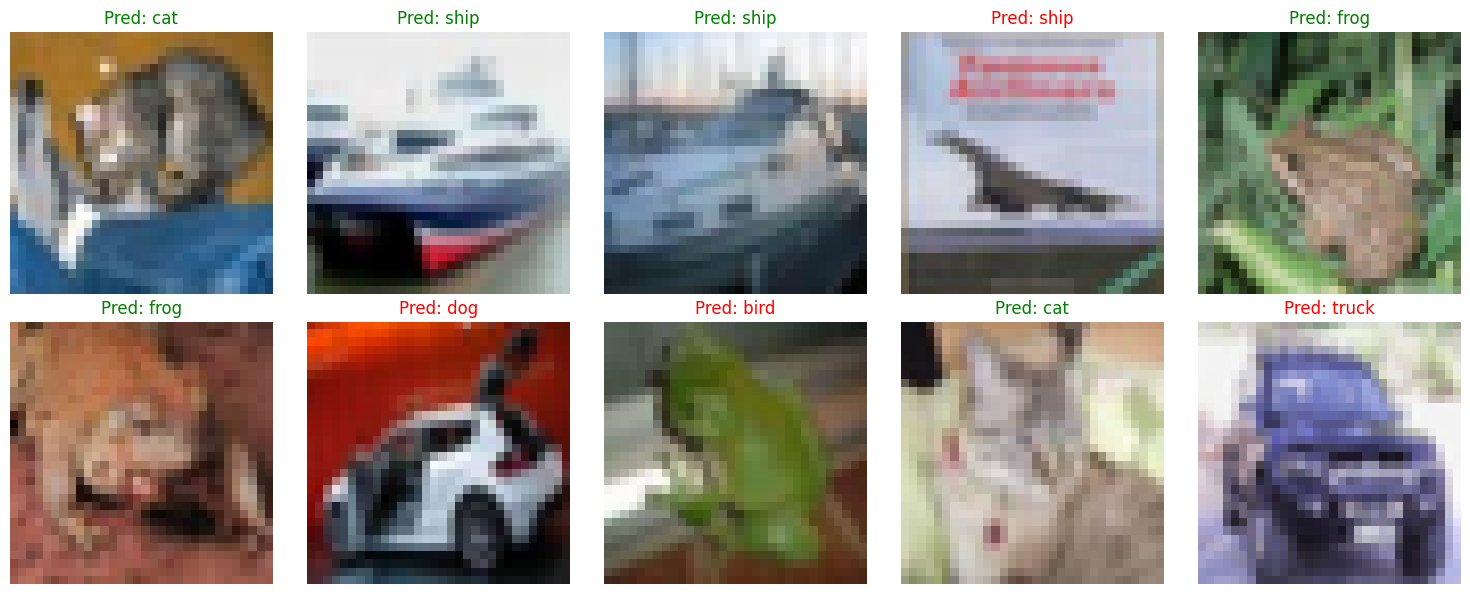

In [15]:
# CIFAR-10 Normalization (for classification)
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10 dataset (labeled)
batch_size = 256
train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

# Load pre-trained encoder and freeze it
encoder = Encoder()
encoder.load_state_dict(torch.load("simclr_encoder.pth"))
encoder.eval()  # Set encoder to evaluation mode (not necessary but good practice)

# Create classifier model
model = Classifier(encoder).to("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Train only the classifier

# Training function for classifier
def train_classifier(model, train_loader, optimizer, criterion, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct, total = 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}, Train Accuracy: {accuracy:.2f}%")

# Test function
def test_classifier(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = outputs.max(1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train and evaluate classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_classifier(model, train_loader, optimizer, criterion, device, epochs=10)
test_classifier(model, test_loader, device)

import matplotlib.pyplot as plt
import numpy as np
import torch

# CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Function to show images with predicted and true labels
def visualize_predictions(model, test_loader, device, num_images=10):
    model.eval()
    images, true_labels, pred_labels = [], [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = outputs.max(1)

            images.extend(x.cpu())  # Store images
            true_labels.extend(y.cpu().numpy())  # Store true labels
            pred_labels.extend(predicted.cpu().numpy())  # Store predicted labels

            if len(images) >= num_images:
                break  # Stop when we have enough images

    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()  # Convert from tensor to image
        img = (img * 0.5) + 0.5  # Unnormalize

        true_label = class_names[true_labels[i]]
        pred_label = class_names[pred_labels[i]]

        # Choose color: Green if correct, Red if wrong
        color = "green" if true_label == pred_label else "red"

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Pred: {pred_label}", color=color)
        axes[i].set_xlabel(f"True: {true_label}")

    plt.tight_layout()
    plt.show()

# Run visualization
visualize_predictions(model, test_loader, device, num_images=10)

